<a href="https://colab.research.google.com/github/wesmail/HADES_Hydra/blob/pid/Hades_Pid_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.2.0 torchvision==0.4.0

     |████████████████████████████████| 748.9 MB 657 bytes/s 
     |████████████████████████████████| 8.8 MB 12.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (device)

cuda:0


In [5]:
class PidDataSet(Dataset):
    '''
    Create Hades Pid Dataset
    '''
    def __init__(self, directory, key='simu'):
        '''
        Parameters:
        directory (str): path where the csv is stored
        start     (int): start event to read
        end       (int): last event to read  
        '''        
        self.__path        = directory
        self.__key         = key
        self.__events      = self.__load_events()
        self.__X, self.__y = self.__items()
    
    def __load_events(self, verbose=False):
        '''
        Returns:
        list: Returning a list of dataframes        
        '''
        return pd.read_csv(self.__path, compression='zip')

    def __len__(self):
        return len(self.__X)
    
    def __items(self):
        df = self.__events
        X  = None
        y  = None
        if self.__key == 'simu':            
            data = df[['momentum','theta','phi','mdcdedx','tofdedx','distmeta','rectof','pid']].to_numpy()
            X, y = data[:,0:-1], data[:,-1]
            
        elif self.__key == 'data':
            data = df[['momentum','theta','phi','mdcdedx','tofdedx','distmeta','rectof']].to_numpy()
            X, y = data, data
            
        return X, y

    
    def __getitem__(self, idx):       
        return torch.FloatTensor(self.__X[idx]), torch.FloatTensor([self.__y[idx]])
    
    def getX(self):
        return self.__X
    
    def gety(self):
        return self.__y   
    
    def get(self):
        '''
        Get the event list.
        '''
        return self.__events        

In [6]:
path = 'https://raw.githubusercontent.com/wesmail/HADES_Hydra/pid/Files/'

In [7]:
# create data object for real data and simulations
simu = PidDataSet(path+'simulations.csv', key='simu')
data = PidDataSet(path+'data.csv', key='data')

In [8]:
# batch_size
batch_size = int(2*1024)

# create mini-batches of data
simuloader = DataLoader(simu, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
# Auto-encoder model
class Model(torch.nn.Module):
    def __init__(self, dim=7, hidden_size=512, activation=torch.nn.Tanh, dorpout=0.5, n_classes=3):
        super(Model, self).__init__()
        self.encoder = torch.nn.Sequential(torch.nn.Linear(dim, hidden_size),
                                     activation(),
                                     torch.nn.Dropout(p=dorpout),
                                     torch.nn.Linear(hidden_size, hidden_size//2),
                                     activation(),
                                     torch.nn.Dropout(p=dorpout),
                                     torch.nn.Linear(hidden_size//2, hidden_size//4),
                                     activation())
        
        self.decoder = torch.nn.Sequential(torch.nn.Linear(hidden_size//4, hidden_size//2),
                                     activation(),
                                     torch.nn.Dropout(p=dorpout),
                                     torch.nn.Linear(hidden_size//2, hidden_size),
                                     activation(),
                                     torch.nn.Dropout(p=dorpout),                                     
                                     torch.nn.Linear(hidden_size, dim))        
        
        self.output = torch.nn.Linear(hidden_size//4, n_classes)

    def forward(self, x_data, x_simu):
        hidden1 = self.encoder(x_data)
        hidden2 = self.encoder(x_simu)
        
        output1 = self.decoder(hidden1) # real data
        output2 = self.output(hidden2)  # simulations

        return output1, F.log_softmax(output2, dim=1)

    
net = Model().to(device)
print(net)    

Model(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=512, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=7, bias=True)
  )
  (output): Linear(in_features=128, out_features=3, bias=True)
)


In [10]:
# learning rate
lr = 1e-3
# number of iterations
kEpochs = 10
# create an optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
mse = torch.nn.MSELoss()
cross_entropy = torch.nn.CrossEntropyLoss()

# run the main training loop
total_step = len(simuloader)
for epoch in range(kEpochs):
    correct = 0
    total   = 0
    for (i_batch, (X_simu, y_simu)), (_, (X_data, y_data)) in zip(enumerate(simuloader), enumerate(dataloader)):
        X_simu = X_simu.to(device)
        X_data = X_data.to(device)
        
        y_simu = y_simu.view(-1).long().to(device) # simulations labels (pi+:0, p:1, K+:2)

        optimizer.zero_grad()
        out_data, out_simu = net.forward(X_data, X_simu)
        l_simu = cross_entropy(out_simu, y_simu) # labeled data loss (simulations)
        l_data = mse(out_data, X_data)           # unlabeled data loss (real data)
        
        loss   = l_simu + l_data                 # add both losses
        loss.backward()
        optimizer.step()

        correct = (torch.max(torch.exp(out_simu),1)[1]==y_simu).int().sum().item()/batch_size

        if (i_batch+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}'\
                   .format(epoch+1, kEpochs, i_batch+1, total_step, loss.item(), correct))

Epoch [1/10], Step [10/48], Loss: 116.0832, Acc: 0.3408
Epoch [1/10], Step [20/48], Loss: 122.4378, Acc: 0.3301
Epoch [1/10], Step [30/48], Loss: 100.5130, Acc: 0.3257
Epoch [1/10], Step [40/48], Loss: 202.7809, Acc: 0.3550
Epoch [2/10], Step [10/48], Loss: 194.9000, Acc: 0.3506
Epoch [2/10], Step [20/48], Loss: 118.6077, Acc: 0.3496
Epoch [2/10], Step [30/48], Loss: 125.4563, Acc: 0.3354
Epoch [2/10], Step [40/48], Loss: 131.5827, Acc: 0.3569
Epoch [3/10], Step [10/48], Loss: 115.8654, Acc: 0.3774
Epoch [3/10], Step [20/48], Loss: 137.8528, Acc: 0.3911
Epoch [3/10], Step [30/48], Loss: 108.8680, Acc: 0.4023
Epoch [3/10], Step [40/48], Loss: 99.2952, Acc: 0.4551
Epoch [4/10], Step [10/48], Loss: 118.9980, Acc: 0.5718
Epoch [4/10], Step [20/48], Loss: 110.2869, Acc: 0.6304
Epoch [4/10], Step [30/48], Loss: 114.7042, Acc: 0.6694
Epoch [4/10], Step [40/48], Loss: 203.4841, Acc: 0.6963
Epoch [5/10], Step [10/48], Loss: 110.6917, Acc: 0.5659
Epoch [5/10], Step [20/48], Loss: 144.2132, Acc: 

In [11]:
# testing phase
model = net.cpu()
model.eval()

Model(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=512, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=7, bias=True)
  )
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [12]:
def plot_confusion_matrix(model):
    '''
    function to plot the confusion matrix
    '''
    # quick and dirty check
    X, ytrue = next(iter(simuloader))
    ytrue = ytrue.view(-1).detach().cpu().numpy()
    # make predictions 'yhat'
    _, yhat = model.forward(X,X)
    # select the largest output
    yhat = (torch.max(torch.exp(yhat),1))[1].detach().cpu().numpy()
    
    # calculate the confusion matrix
    cm = confusion_matrix(ytrue, yhat)
    cm = (cm.astype('float') / cm.sum(axis=1))
    
    # plot the confusion matrix as a heatmap
    sns.set(font_scale=1.5)
    sns.heatmap(cm, square=True, annot=True, annot_kws={"size": 15}, cmap='Blues')
    classes=['$\pi^{+}$', '$p$', '$K^{+}$']
    plt.xticks(np.arange(len(classes))+0.5, ('$\pi^{+}$', '$p$', '$K^{+}$'),rotation=45)
    plt.yticks(np.arange(len(classes))+0.5, ('$\pi^{+}$', '$p$', '$K^{+}$'),rotation=45)
    plt.xlabel('Predication', horizontalalignment = 'center',  fontsize=15)
    plt.ylabel('True Species',  fontsize=15)
    plt.tight_layout()

def enable_dropout(m):
    '''
    enable dropout during inference
    '''
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
            each_module.train()
            
def serialize_to_torchscript(network, name='model_cpp.pt'):
    '''
    save the trained model as a
    torchscript model to load in
    a C++ enviroment
    '''
    model = network.cpu()
    model.eval()
    #enable_dropout(model)
    X, _ = next(iter(simuloader))
    # run the tracing
    traced_script_module = torch.jit.trace(model, (X, X))
    # save the converted model
    traced_script_module.save(name)

def plot_roc_curve(model):
    '''
    function to plot the ROC curve
    '''
    # quick and dirty
    X, ytrue = next(iter(simuloader))
    _, yhat = model(X, X)
    yhat = torch.exp(yhat).detach().numpy()
    ytrue = label_binarize(ytrue, classes=[0, 1, 2])
    n_classes = ytrue.shape[1]
    
    lw=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yhat[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    plt.plot(fpr[1], tpr[1], color='yellowgreen', lw=lw, label='AUC for {0}   ( = {1:0.2f})'.format('$p$',roc_auc[1]))
    plt.plot(fpr[0], tpr[0], color='blue', lw=lw, label='AUC for {0} ( = {1:0.2f})'.format('$\pi^{+}$',roc_auc[0]))
    plt.plot(fpr[2], tpr[2], color='red', lw=lw, label='AUC for {0} ( = {1:0.2f})'.format('$K^{+}$',roc_auc[2]))

    plt.xlim([0.0, 0.5])
    plt.ylim([0.5, 1.0])
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right', fontsize=15) 
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.show()       

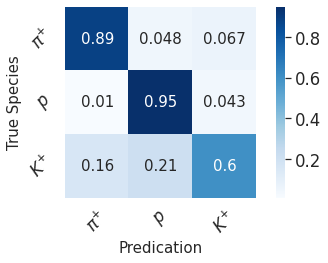

In [13]:
# the confusion matrix
plot_confusion_matrix(model)

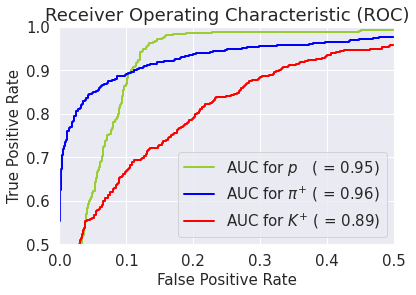

In [14]:
# the ROC curve
plot_roc_curve(model)

In [15]:
# save a 'C++' version of the trained model
serialize_to_torchscript(model, 'model_cpp.pt') 

In [17]:
!pwd

/content
